# Tutorial for Tasks 2 and 3: Classification of frames
This notebook illustrates how to:
- define a Python fonction which produces solutions for tasks 2 or 3;
- run this function;
- evaluate its performance.

## Dataset loading
First, let us load the dataset. In this tutorial we use the complete version of the dataset, and we shuffle it to select random examples from the complete set. The `random_state` enables you to force the initialization the random number generator and reproduce the results.

In [1]:
from smartdoc15_ch1 import Dataset, Models, evaluate_segmentation

In [2]:
d = Dataset(shuffle=True, random_state=0)

We also load the models to read their images.

In [3]:
models = Models(variant=Models.VARIANT_05_SCALED33)

## Tasks definition
Tasks 2 and 3 are classification tasks.
Given a frame image, you should return:
- the class of the model for task 2: `0` if the frame contains an instance of "datasheet001", `1` for "datasheet002", ..., and `29` for "tax005"
- the class of the model type for task 3: `0` if the frame contains an instance of any "datasheet" model, `1` for "letter", `2` for "magazine", `3` for "paper", `4` for "patent" and `5` for "tax".

The following figures illustrate the expected outputs for tasks 2 and 3.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

### Expected outputs for Tasks 2 and 3

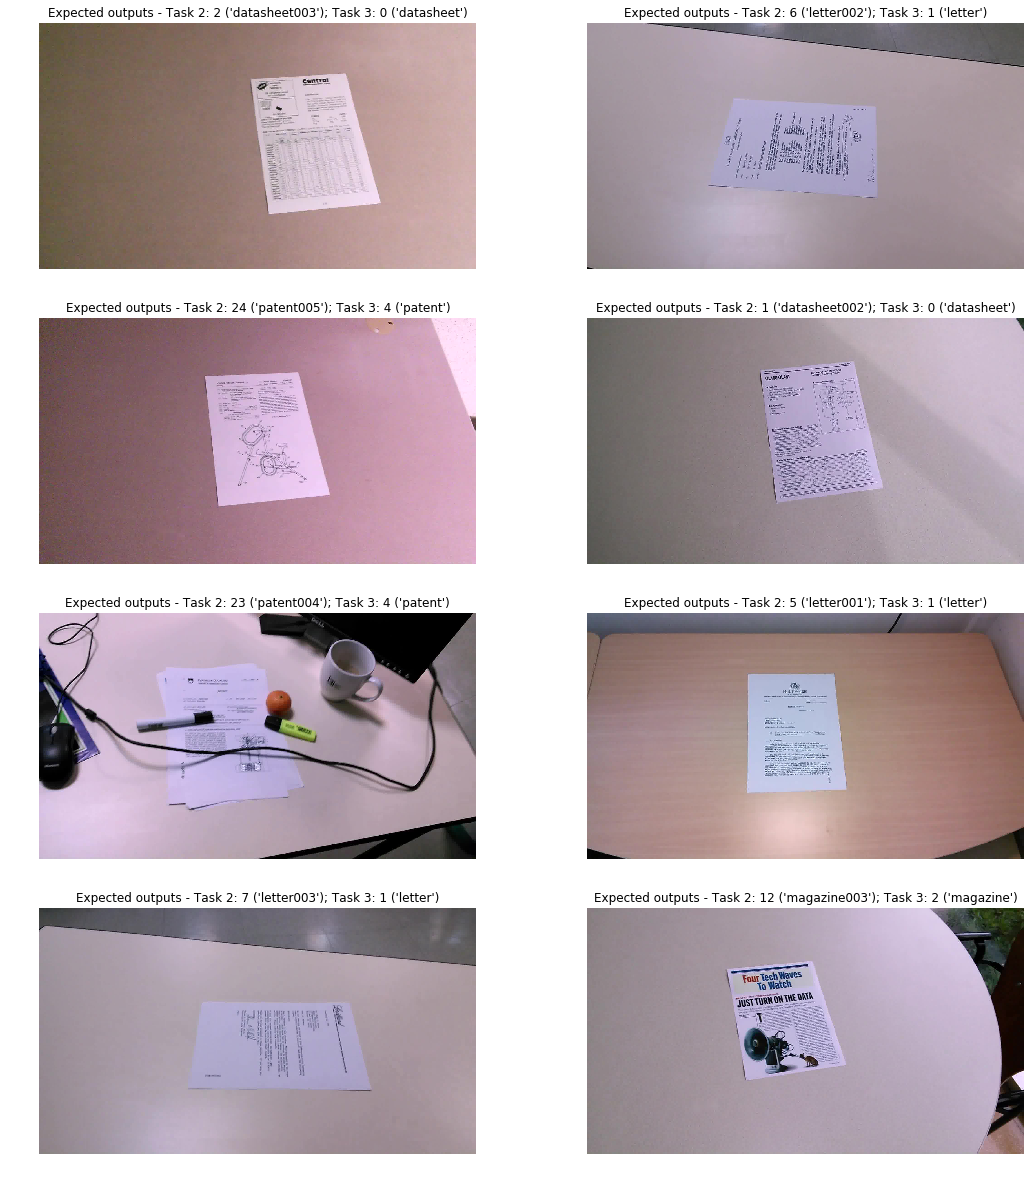

In [5]:
num_frames = 8
plt.figure(figsize=(18,2.6*num_frames))
for ii, frame in enumerate(d[:num_frames]):
    plt.subplot(num_frames//2,2,ii+1)
    plt.imshow(frame.read_image(color=True))
    plt.title("Expected outputs - Task 2: %d ('%s'); Task 3: %d ('%s')" 
              % (frame["model_id"], frame["model_name"], frame["modeltype_id"], frame["modeltype_name"]))
    plt.axis('off')
plt.show()

### Evaluation procedure

The evaluation function `evaluate_classification` is a very basic wrapper around scikit-learn metrics. You may want to compute classification performance using your own metrics to investigate your results better.
However, the evaluation function we provide is a simple and easy solution to estimate the performance of your approach. It requires:
- the target classification labels, which can be obtained using `Dataset.model_classif_targets` for task 2 or `Dataset.modeltype_classif_targets` for task 3;
- the predicted classification labels for all the frames, in the exact same order.

The correspondances between the model names (resp. model type names) and the model ids (resp. model type ids) are printed out below:

In [6]:
print("model_id : model_name")
print("-----------------------")
for model_id, model_name in zip(d.unique_model_ids, d.unique_model_names):
    print("%8d : %s" % (model_id, model_name))

model_id : model_name
-----------------------
       0 : datasheet001
       1 : datasheet002
       2 : datasheet003
       3 : datasheet004
       4 : datasheet005
       5 : letter001
       6 : letter002
       7 : letter003
       8 : letter004
       9 : letter005
      10 : magazine001
      11 : magazine002
      12 : magazine003
      13 : magazine004
      14 : magazine005
      15 : paper001
      16 : paper002
      17 : paper003
      18 : paper004
      19 : paper005
      20 : patent001
      21 : patent002
      22 : patent003
      23 : patent004
      24 : patent005
      25 : tax001
      26 : tax002
      27 : tax003
      28 : tax004
      29 : tax005


In [7]:
print("modeltype_id : modeltype_name")
print("-----------------------------")
for modeltype_id, modeltype_name in zip(d.unique_modeltype_ids, d.unique_modeltype_names):
    print("%12d : %s" % (modeltype_id, modeltype_name))

modeltype_id : modeltype_name
-----------------------------
           0 : datasheet
           1 : letter
           2 : magazine
           3 : paper
           4 : patent
           5 : tax


The signature of the function we have to code is therefore:

       np.array ---> integer
    input image |--> predicted classification label

## A simple frame classifier
We now define a simple function which makes use of OpenCV primitives to quickly classify a frame according to the detected model.

We use the ORB local descriptors, and "train" our "classifier" using the reduced model images.

You may need to install (locally) the Python wrapper for OpenCV by entering the following command in your shell:

    pip install opencv-python

In [8]:
import numpy as np
import cv2

We first create a local descriptor extractor, and a matcher. The first produced a set of (keypoint, descriptor) for each image, and the second indexes such data along with the source model id it was extracted from. The matcher will enable to look for each (keypoint, descriptor) couple extracted from a given image, and obtain the id of the most probable model. By gathering the correspondances between each (keypoint, descriptor) couple from the current frame and the model database, we can:
1. validate the geometrical consistency of the matches;
2. return the most probable model id for all the consistent matches we got.

In [9]:
detector = cv2.ORB_create(1000, 
                   scaleFactor=1.2, 
                   nlevels=25,
                   edgeThreshold=5,
                   firstLevel=0,
                   WTA_K=2,
                   scoreType=1,
                   patchSize=15)
matcher = cv2.FlannBasedMatcher({'algorithm': 6,
                                 'table_number': 6,
                                 'key_size': 12,
                                 'multi_probe_level': 1},
                                {})

Let us now read all the model images, detect the keypoints and compute their local descriptors, then the set of (keypoint, descriptor) in the matcher.

In [10]:
all_keypoints = []
for model_image in models.iter_model_images():
    keyp_mdli, desc_mdli = detector.detectAndCompute(np.uint8(model_image), mask=None)
    matcher.add([desc_mdli])  # associates all the descriptors to the next available index
    all_keypoints.append(keyp_mdli)

In [11]:
len(all_keypoints[2])

955

In [7]:
TODO

### Process the previous image

In [8]:
# TODO

(716, 236, 848, 844, 1332, 744, 1140, 180)

### Display the classification (expected and predicted)

## Evaluating the performance on Task 2
Our document object detector seems to work (at least on this image). Let us now test it on the a sample of the dataset.

We will process all images and store the classification results, then we will call the evaluation function.

On the real dataset, you may want to parallelize such process, using the Joblib library for instance.

**The code in the two cells below is the only code you need (beside your function definition) to evaluate a given frame classification function.**

If you want to evaluate the performance of an external (non Python) program for this task, you will need to:
1. process the images in the canonical order of the dataset (see the "frames/metadata.csv.gz" file) and store results with this same order;
2. open and parse your result file(s) in Python produce a single list or array of `n` rows, `n` being the number of frames;
3. call the `evaluate_segmentation` function with the appropriate values.

In [ ]:
sample_size = 50

In [11]:
predicted_labels = []
for ii, frame in enumerate(d[:sample_size]):
    print("Processing image %2d/%d: %s" % (ii+1, len(d), frame["image_path"]))
    predicted_labels.append(detect_model_label(frame.read_image(color=True)))

Processing image  1/50: background01/datasheet004/frame_0181.jpeg
Processing image  2/50: background02/tax003/frame_0128.jpeg
Processing image  3/50: background03/patent002/frame_0163.jpeg
Processing image  4/50: background04/letter001/frame_0116.jpeg
Processing image  5/50: background02/magazine001/frame_0045.jpeg
Processing image  6/50: background05/patent001/frame_0062.jpeg
Processing image  7/50: background04/patent005/frame_0048.jpeg
Processing image  8/50: background02/patent002/frame_0106.jpeg
Processing image  9/50: background03/tax002/frame_0158.jpeg
Processing image 10/50: background02/datasheet003/frame_0129.jpeg
Processing image 11/50: background04/letter001/frame_0094.jpeg
Processing image 12/50: background01/datasheet004/frame_0130.jpeg
Processing image 13/50: background04/paper002/frame_0071.jpeg
Processing image 14/50: background02/paper001/frame_0209.jpeg
Processing image 15/50: background02/paper003/frame_0029.jpeg
Processing image 16/50: background01/paper004/frame_0

In [12]:
metrics = evaluate_segmentation(predicted_segmentations, d.segmentation_targets, 
                                d.model_shapes, print_summary=True)

----------------------------------------------
   evaluate_segmentation: Evaluation report
----------------------------------------------
metric: IoU (aka Jaccard index)
----------------------------------------------
observations:    50
mean:             0.70 (CI@95%: 0.583, 0.808)
min-max:          0.000 - 0.988
variance:         0.165 (std: 0.406)
----------------------------------------------


In [13]:
# Alternate version using the compact `iter_frame_images` function
# predicted_segmentations = []
# for ii, frame_image in enumerate(d.iter_frame_images(color=True)):
#     print("Processing image %2d/%d" % (ii+1, len(d)))
#     predicted_segmentations.append(detect_object(frame_image))

In [14]:
# or ever shorter
# predicted_segmentations = [detect_object(img) for img in d.iter_frame_images(color=True)]

## Check the results
We can now study which kind of input cause our function to perform well or not.

Let us simply plot the results for the best and the worst scoring images.

In [15]:
bfid = np.argmax(metrics)
best_frame = d[bfid]
wfid = np.argmin(metrics)
worst_frame = d[wfid]

In [16]:
def seg2xylists(seg):
    seg_x = tuple(seg[0::2]) + (seg[0],)
    seg_y = tuple(seg[1::2]) + (seg[1],)
    return seg_x, seg_y

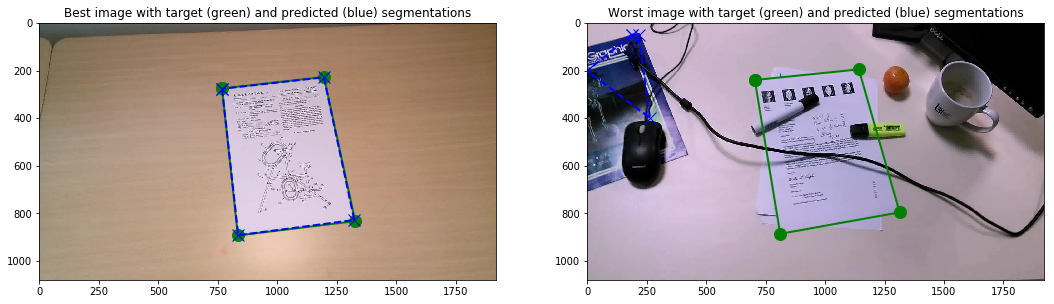

In [17]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.imshow(best_frame.read_image(color=True))
seg_x, seg_y = seg2xylists(d.segmentation_targets[bfid])
plt.plot(seg_x, seg_y, 'go-', linewidth=2, markersize=12)
seg_x, seg_y = seg2xylists(predicted_segmentations[bfid])
plt.plot(seg_x, seg_y, 'bx--', linewidth=2, markersize=12)
plt.title("Best image with target (green) and predicted (blue) segmentations")
plt.subplot(1,2,2)
plt.imshow(worst_frame.read_image(color=True))
seg_x, seg_y = seg2xylists(d.segmentation_targets[wfid])
plt.plot(seg_x, seg_y, 'go-', linewidth=2, markersize=12)
seg_x, seg_y = seg2xylists(predicted_segmentations[wfid])
plt.plot(seg_x, seg_y, 'bx--', linewidth=2, markersize=12)
plt.title("Worst image with target (green) and predicted (blue) segmentations")
plt.show()